<a href="https://colab.research.google.com/github/Kidus-Bellete/Face-and-non-face-recognition/blob/main/Face_non_Face_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing Packages**

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
import time

warnings.filterwarnings("ignore")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **load images from file**

In [6]:
# function to laad images from a folder structure
def load_images(path):
    images = []
    labels = []
    if path:
        for i, dir in enumerate(os.listdir(path)):
            for file in os.listdir(os.path.join(path, dir)):
                img = Image.open(os.path.join(path, dir, file)).convert('L')
                img = img.resize((92,112))
                images.append(np.array(img).flatten())
                labels.append(i+1)

    return np.array(images), np.array(labels).reshape(-1,1)
faces, labels = load_images('/content/drive/MyDrive/Colab Notebooks/ML_project_classification/datasets/faces')
non_faces, non_labels = load_images('/content/drive/MyDrive/Colab Notebooks/ML_project_classification/datasets/nonfaces')
faces_labels = np.ones((len(faces),1))
non_faces_labels = np.zeros((len(non_faces),1))
print(faces.shape, faces_labels.shape)
print(non_faces.shape, non_faces_labels.shape)


(400, 10304) (400, 1)
(550, 10304) (550, 1)


In [20]:
print(faces_labels[99])

[1.]


## **Suffle the images and labels**

In [8]:
def shuffle_data(data, labels):
    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)
    return data[idx], labels[idx]

faces, labels = shuffle_data(faces, faces_labels)
non_faces, non_labels = shuffle_data(non_faces, non_faces_labels)

## **Apply Normalization**

In [9]:
# Normalization using Min-Max scaling
def min_max_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

# Apply Min-Max scaling
faces = min_max_scaling(faces)
non_faces = min_max_scaling(non_faces)

print("\nNormalized data shapes:")
print("Faces:", faces.shape, faces_labels.shape)
print("Non-Faces:", non_faces.shape, non_faces_labels.shape)


Normalized data shapes:
Faces: (400, 10304) (400, 1)
Non-Faces: (550, 10304) (550, 1)


## **Plot the data**

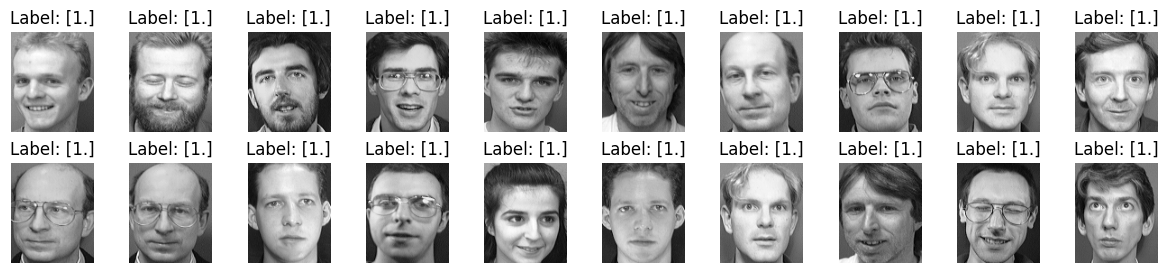

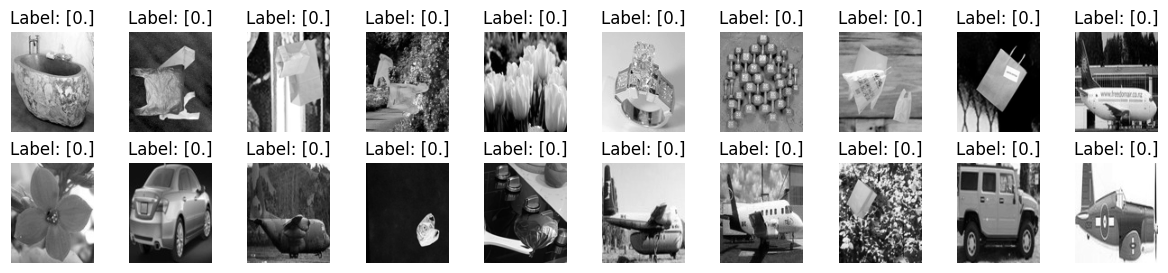

In [10]:
def plot_data(faces, labels, n=100):
    num_rows = n // 10
    fig, axs = plt.subplots(num_rows, 10, figsize=(15, 1.5 * num_rows), gridspec_kw={'hspace': 0.3})
    axs = axs.ravel()
    for i in range(n):
        axs[i].imshow(faces[i].reshape((112, 92)), cmap="gray")
        axs[i].set_title(f"Label: {labels[i]}")
        axs[i].axis("off")
    plt.show()

plot_data(faces, labels,20)
plot_data(non_faces, non_labels,20)

## **Split the dataset into training and testing**

In [11]:
def train_test_split(X, y, test_size=0.3, random_state = 42):

    # number of features
    m, n = X.shape
    # train size
    tsize = int(test_size * X.shape[0]) - 1
    # declare returned variables
    X_train, X_test, y_train, y_test = [], [], [], []
    # create random indices
    indices = np.random.randint(low=0, high=X.shape[0], size=tsize)
    # loop through all samples and select the train and test sets
    for i in range(m):
        if i in indices:
          X_test.append(X[i])
          y_test.append(y[i])
        else:
          X_train.append(X[i])
          y_train.append(y[i])
    # transform into np arrayes
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
    return X_train, X_test, y_train, y_test


In [12]:
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(faces, labels)
X_n_train, X_n_test, y_n_train, y_n_test = train_test_split(non_faces,non_labels)

# Concatenate the training data and labels
X_train = np.concatenate((X_f_train, X_n_train), axis=0)
y_train = np.concatenate((y_f_train, y_n_train), axis=0)

# Concatenate the testing data and labels
X_test = np.concatenate((X_f_test, X_n_test), axis=0)
y_test = np.concatenate((y_f_test, y_n_test), axis=0)
print(X_train.shape)

(706, 10304)


## **display samples of training data and test data**

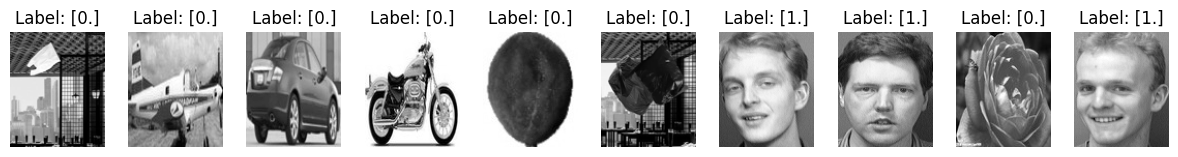

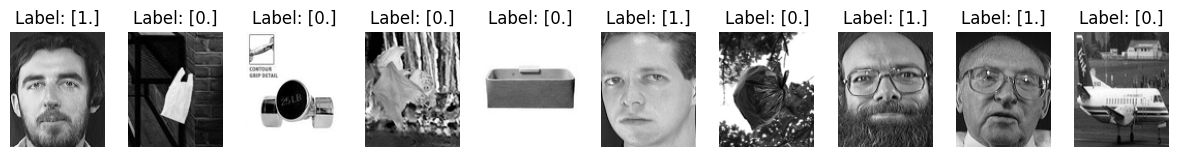

(706, 10304)


In [13]:
X_train, y_train=shuffle_data(X_train, y_train)
X_test, y_test = shuffle_data(X_test, y_test)

plot_data(X_train, y_train,10)
plot_data(X_test, y_test,10)
print(X_train.shape)

## **PCA implementation**

In [14]:
def PCA(train_data,alpha=0.95):
    mean = np.mean(train_data, axis=0)
    centered_data = train_data - mean

    cov_matrix = np.dot(centered_data,centered_data.T)
    # cov_matrix = np.cov(centered_data,rowvar=False,bias=True)
    eig_values, eig_vectors = np.linalg.eigh(cov_matrix)

    idx = np.argsort(eig_values)[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:,idx]

    eig_vectors = np.dot(centered_data.T,eig_vectors)

    for i in range(eig_vectors.shape[1]):
        eig_vectors[:,i] = eig_vectors[:,i]/np.linalg.norm(eig_vectors[:,i])

    total = np.sum(eig_values)
    k = 0
    var = 0
    while var/total < alpha:
        var += eig_values[k]
        k += 1
    print(f"Using {k} components to retain {alpha*100}% of the variance")
    return eig_vectors[:,:k], mean

space,mean= PCA(X_train,0.85)

Using 52 components to retain 85.0% of the variance


## **Plot the eign images**

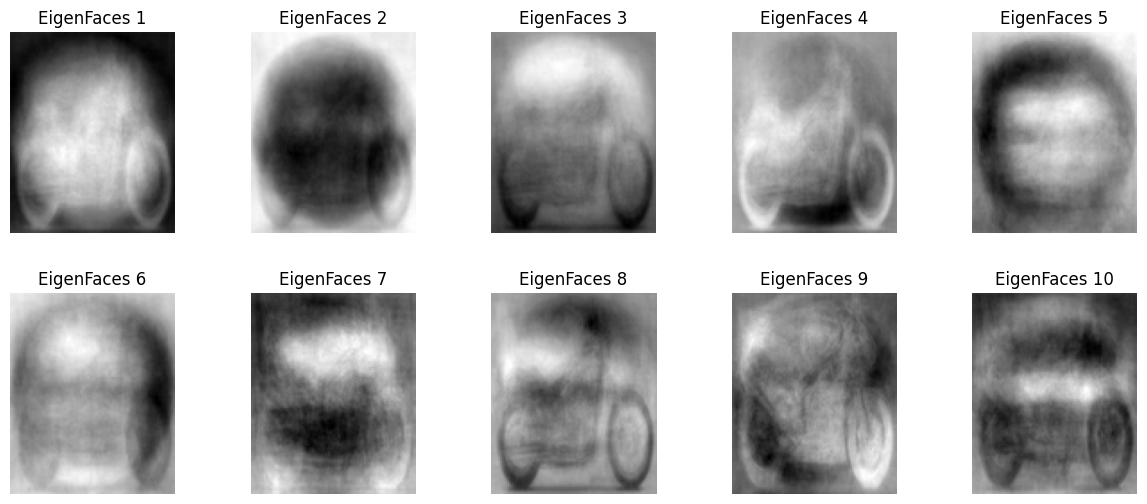

In [15]:
def plot_eigenfaces(eigenvectors, n=10):
    num_rows = n // 5
    _, axs = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows), gridspec_kw={'hspace': 0.3})
    axs = axs.ravel()
    for i in range(n):
        axs[i].imshow(eigenvectors[:, i].reshape((112, 92)), cmap="gray")
        axs[i].set_title(f"EigenFaces {i+1}")
        axs[i].axis("off")
    plt.show()
plot_eigenfaces(space, 10)

## **Project the data using PCA**

In [16]:
def project_data(data, eigenvectors, mean,):
    return np.dot(data - mean, eigenvectors)
train_projected_pca = project_data(X_train, space, mean)
test_projected_pca = project_data(X_test, space, mean)

## **LDA implementation**

In [17]:
def LDA (train_data, train_labels, k=1):
    # mean of each class
    mean1 = np.mean(train_data[train_labels.ravel() == 1], axis=0)
    mean0 = np.mean(train_data[train_labels.ravel() == 0], axis=0)

    # within class scatter matrix
    Sw = np.dot((train_data[train_labels.ravel() == 1] - mean1).T,
                (train_data[train_labels.ravel() == 1] - mean1)) + np.dot((train_data[train_labels.ravel() == 0] - mean0).T,
                                                                          (train_data[train_labels.ravel() == 0] - mean0))
    # between class scatter matrix
    Sb = np.dot((mean1 - mean0).reshape(-1,1), (mean1 - mean0).reshape(-1,1).T)

    # calculating the eigenvalues and eigenvectors
    eig_values, eig_vectors = np.linalg.eigh(np.dot(np.linalg.inv(Sw), Sb))
    eig_values = np.real( eig_values)
    eig_vectors = np.real( eig_vectors)
    idx = np.argsort(eig_values)[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:,idx]
    return eig_vectors[:,:k]

## **project the data using LDA**

In [18]:
lda_space = LDA(X_train, y_train)
train_lda_projected = np.dot(X_train, lda_space)
test_lda_projected = np.dot(X_test, lda_space)

## **Create a list of classifier**
+ Logistics
* SVM
- KNN

min-max normalization
Classifier: LogisticRegression
Training Time: 2.2634 seconds
Training Score: 100.0000
Testing Score: 93.8525


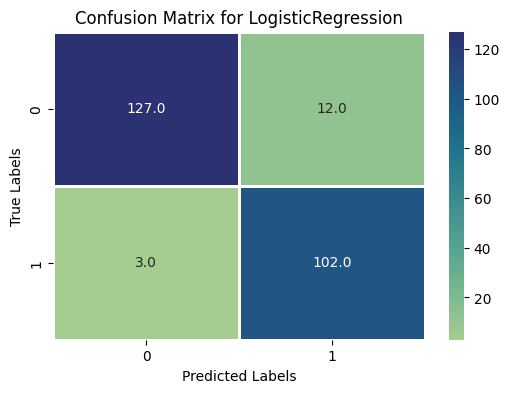

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94       139
         1.0       0.89      0.97      0.93       105

    accuracy                           0.94       244
   macro avg       0.94      0.94      0.94       244
weighted avg       0.94      0.94      0.94       244

------------------------------------------------------------------------------------------------------------------------
PCA
Classifier: LogisticRegression
Training Time: 2.6875 seconds
Training Score: 99.2918
Testing Score: 95.4918


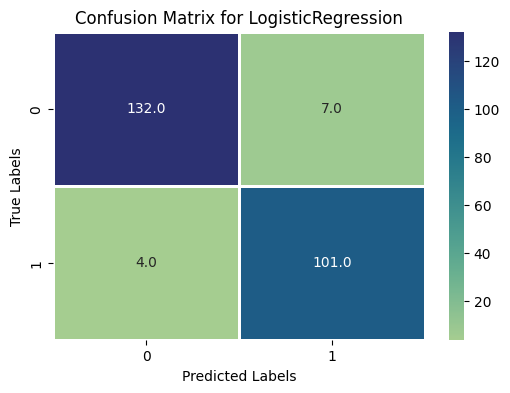

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       139
         1.0       0.94      0.96      0.95       105

    accuracy                           0.95       244
   macro avg       0.95      0.96      0.95       244
weighted avg       0.96      0.95      0.95       244

------------------------------------------------------------------------------------------------------------------------
LDA
Classifier: LogisticRegression
Training Time: 2.9794 seconds
Training Score: 77.0538
Testing Score: 75.0000


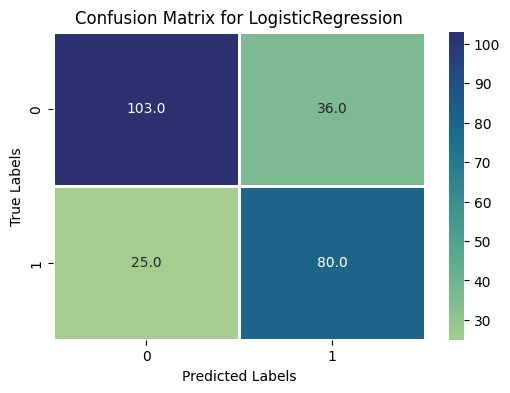

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.74      0.77       139
         1.0       0.69      0.76      0.72       105

    accuracy                           0.75       244
   macro avg       0.75      0.75      0.75       244
weighted avg       0.76      0.75      0.75       244

------------------------------------------------------------------------------------------------------------------------
min-max normalization
Classifier: SVC
Training Time: 1.0606 seconds
Training Score: 99.7167
Testing Score: 98.3607


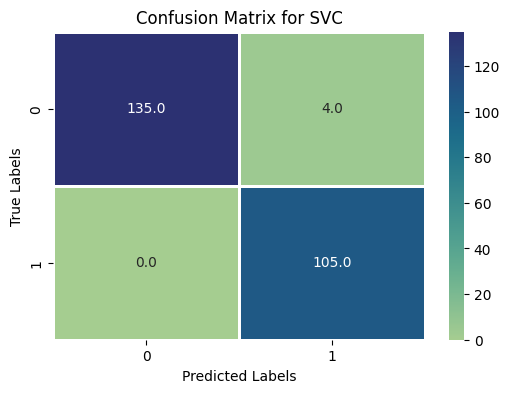

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99       139
         1.0       0.96      1.00      0.98       105

    accuracy                           0.98       244
   macro avg       0.98      0.99      0.98       244
weighted avg       0.98      0.98      0.98       244

------------------------------------------------------------------------------------------------------------------------
PCA
Classifier: SVC
Training Time: 4.1202 seconds
Training Score: 99.5751
Testing Score: 96.7213


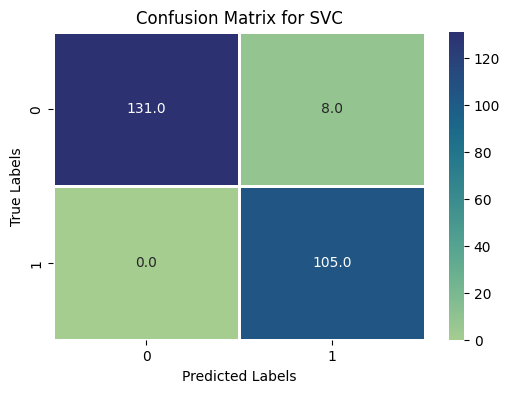

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97       139
         1.0       0.93      1.00      0.96       105

    accuracy                           0.97       244
   macro avg       0.96      0.97      0.97       244
weighted avg       0.97      0.97      0.97       244

------------------------------------------------------------------------------------------------------------------------
LDA
Classifier: SVC
Training Time: 4.5472 seconds
Training Score: 81.1615
Testing Score: 80.3279


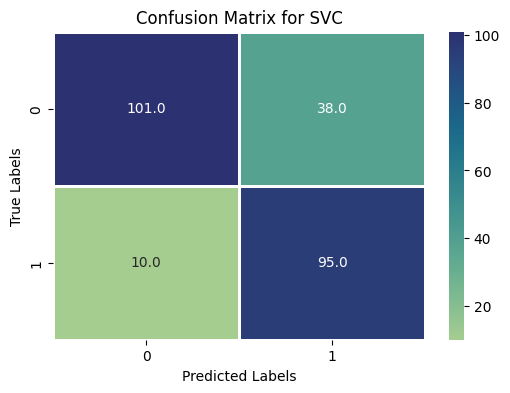

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.73      0.81       139
         1.0       0.71      0.90      0.80       105

    accuracy                           0.80       244
   macro avg       0.81      0.82      0.80       244
weighted avg       0.83      0.80      0.80       244

------------------------------------------------------------------------------------------------------------------------
min-max normalization
Classifier: KNeighborsClassifier
Training Time: 0.0089 seconds
Training Score: 93.7677
Testing Score: 91.3934


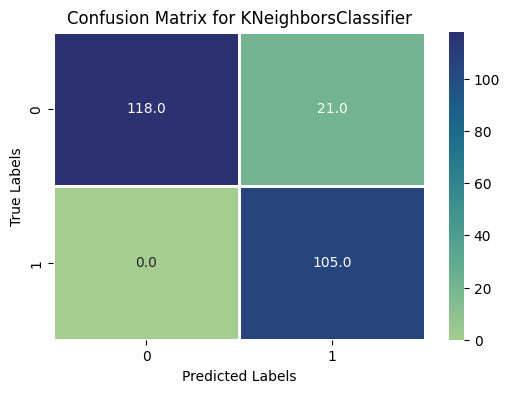

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92       139
         1.0       0.83      1.00      0.91       105

    accuracy                           0.91       244
   macro avg       0.92      0.92      0.91       244
weighted avg       0.93      0.91      0.91       244

------------------------------------------------------------------------------------------------------------------------
PCA
Classifier: KNeighborsClassifier
Training Time: 2.2111 seconds
Training Score: 95.0425
Testing Score: 90.9836


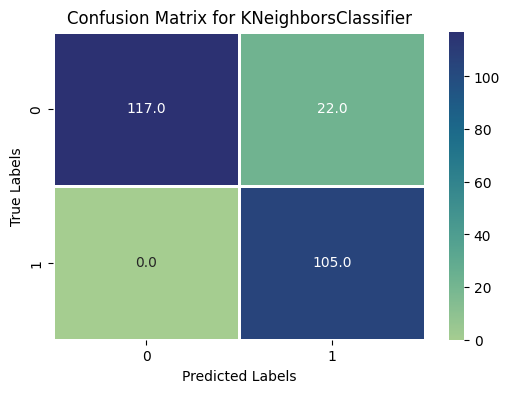

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91       139
         1.0       0.83      1.00      0.91       105

    accuracy                           0.91       244
   macro avg       0.91      0.92      0.91       244
weighted avg       0.93      0.91      0.91       244

------------------------------------------------------------------------------------------------------------------------
LDA
Classifier: KNeighborsClassifier
Training Time: 3.1949 seconds
Training Score: 85.2691
Testing Score: 77.8689


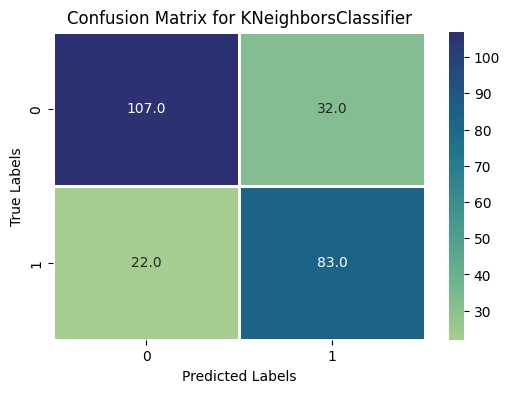

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80       139
         1.0       0.72      0.79      0.75       105

    accuracy                           0.78       244
   macro avg       0.78      0.78      0.78       244
weighted avg       0.78      0.78      0.78       244

------------------------------------------------------------------------------------------------------------------------


In [19]:
# Create a list of classifier instances
classifiers = [
    ("LogisticRegression", LogisticRegression()),
    ("SVC", SVC()),
    ("KNeighborsClassifier", KNeighborsClassifier()),
]

# Initialize lists to store classifier names, training accuracies, and test accuracies
classifier_names = []
train_accuracies = []
test_accuracies = []
training_times = []

X_for_training = [X_train,train_projected_pca, train_lda_projected]
X_for_test = [X_test, test_projected_pca, test_lda_projected]
y_for_training=[y_train,y_train, y_train]
y_for_testing = [y_test,y_test,y_test]
text =['min-max normalization','PCA', 'LDA']
# Iterate through the classifiers and evaluate their performance
for name, classifier in classifiers:
    start_time = time.time()  # Start timing
    for i in range(3):


      classifier.fit(X_for_training[i], y_for_training[i])
      training_time = time.time() - start_time
      y_pred = classifier.predict(X_for_test[i])
      train_score = classifier.score(X_for_training[i], y_for_training[i])
      test_score = classifier.score(X_for_test[i], y_for_testing[i])
      print(text[i])
      print(f"Classifier: {name}")
      print(f"Training Time: {training_time:.4f} seconds")
      print(f"Training Score: {train_score*100:.4f}")
      print(f"Testing Score: {test_score*100:.4f}")

      # Append classifier name, training accuracy, and test accuracy to lists
      classifier_names.append(name)

      train_accuracies.append(train_score)
      test_accuracies.append(test_score)
      training_times.append(training_time)
      conmat = confusion_matrix(y_test, y_pred)

      # Plot confusion matrix as heatmap
      plt.figure(figsize=(6, 4))
      sns.heatmap(conmat, annot=True, fmt=".1f", linewidth=1, cmap="crest")
      plt.xlabel("Predicted Labels")
      plt.ylabel("True Labels")
      plt.title(f"Confusion Matrix for {name}")
      plt.show()

      # Calculate and print classification report
      class_report = classification_report(y_test, y_pred)
      print("Classification Report:")
      print(class_report)

      print("-" * 120)


